# Classify Magnetic Structure

In [1]:
import os
num_thread = 4
os.environ['OMP_NUM_THREADS'] = str(num_thread)
os.environ['OPENBLAS_NUM_THREADS'] = str(num_thread)

import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

from pyhf3 import draw, magstr

name = 'baoso3_dU1.0'
mcns = ['rf', 'xgb', 'lgb', 'cat']
mcnfs = ['(a) RF', '(b) XGB', '(c) LGBM', '(d) CB']
dmft_cols = ['JU', 'N', 'm', 'U', 'type', 'type_p', 'score']
dmft_dict = {
    'N': 'Hz',
    'm': 'D'
}

ms = magstr.MagStr(name, num_thread=num_thread)

# functions
def ShowPeak(name, dn, type, JU, N, U, fermi_idx=0, xlim=20):
    bins = int(re.sub('bins', '', re.search('bins\d+', dn).group()))\
    if re.search('bins', dn)\
    else ms.BINS_MAX
    binsh = bins//2
    
    fmt = ['', '\n', '', '']
    yticks = [0, binsh-1, binsh, bins-1]
    yticklabels = [['%s%s%02d%s'%(f, l, i+1, b)\
                    for i, f, b in zip(yticks, fmt, fmt[::-1])]\
                   for l in ms.labels]
    
    fig, ax = plt.subplots(1, 4,\
                           figsize=(14, 6),\
                           dpi=300,\
                           constrained_layout=True)
    
    for i in range(ms.Nhsp):
        y, _, peak = ms.DrawDOS(dn, type[0], JU, N, U, fermi_idx=fermi_idx, point=i)
        x = range(len(y))
        ax[i].barh(x[:binsh], y[:binsh])
        ax[i].barh(x[binsh:], y[binsh:], color='tab:red')
        ax[i].text(0.9, 0.95, ms.labels[i].replace('G', r'$\Gamma$'),\
                   transform=ax[i].transAxes, size=28, va='top', ha='right',\
                   bbox=dict(boxstyle='square', fc='none', ec='k'))
        ax[i].set_xlim(0, xlim*1.2)
        ax[i].set_xticks([0, xlim], labels=[0, xlim], fontsize='small')
        ax[i].set_yticks(yticks, yticklabels[i], fontsize='small')
        ax[i].axhline(np.median(x), ls=':', lw=2, color='dimgrey')

        for j in range(ms.PEAK_MAX):
            color = 'r' if peak[j][1] > binsh else 'b'
            coord = (peak[j][0]+xlim*0.1, peak[j][1])
            ax[i].annotate('', xy=coord, xycoords='data',\
                          xytext=(coord[0]+xlim*0.3, coord[1]), textcoords='data',
                          arrowprops=dict(arrowstyle="simple",\
                                          connectionstyle="arc3",\
                                          color=color))
    ax[0].set_ylabel('Feature index', fontsize='large')
    ax[1].set_xlabel(r'                   $\rho_{\bf{k}}$', fontsize='large')
    fig.savefig('diagram/%s/dmft/peak.pdf' % name)
    plt.show()
def ShowConfMats(dn, mcns, mcnfs, verbose=False, pca=False, show_xticks=True):
    fig, ax = plt.subplots(1, 4, figsize=(18, 5), constrained_layout=True)
    labels = ['A', 'C', 'G']
    is_validate = True if type(dn) is list else False
    show_yticks = True
    xpad = -0.4
    ypad = -0.12
    
    for i, (mcn, mcnf) in enumerate(zip(mcns, mcnfs)):
        if is_validate: y = ms.Validate(dn[0], dn[1], mcn, verbose=verbose, pca=pca)
        else:           y = ms.Train(dn, mcn, verbose=verbose, pca=pca)
        
        im = ms.DrawConfMat(y[0], y[1], ax[i])
        
        ax[i].set_title(mcnf, ha='left', x=xpad, y=1.1)
        ax[i].set_xticks(range(3))
        ax[i].set_yticks(range(3))
        ax[i].set_xticklabels(labels)
        ax[i].set_yticklabels(labels)
        ax[i].set_ylabel('\nTrue', fontsize='large')
        
        if not show_xticks:
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('')
        if not show_yticks:
            ax[i].set_yticklabels([])
            ax[i].set_ylabel('')
            
        show_yticks = False
        xpad = -0.1
            
    cb = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.75, pad=0.02)
    cb.set_ticks([0, 1])
    fig.get_layout_engine().set(wspace=0.1)
    xlabel = 'Predicted' if show_xticks else ' '
    fname = dn[1] if is_validate else dn
    fig.supxlabel(xlabel, fontsize='large', y=ypad)
    fig.savefig('diagram/%s/conf_%s.pdf' % (name, fname), bbox_inches='tight')
    plt.show()

## Peak

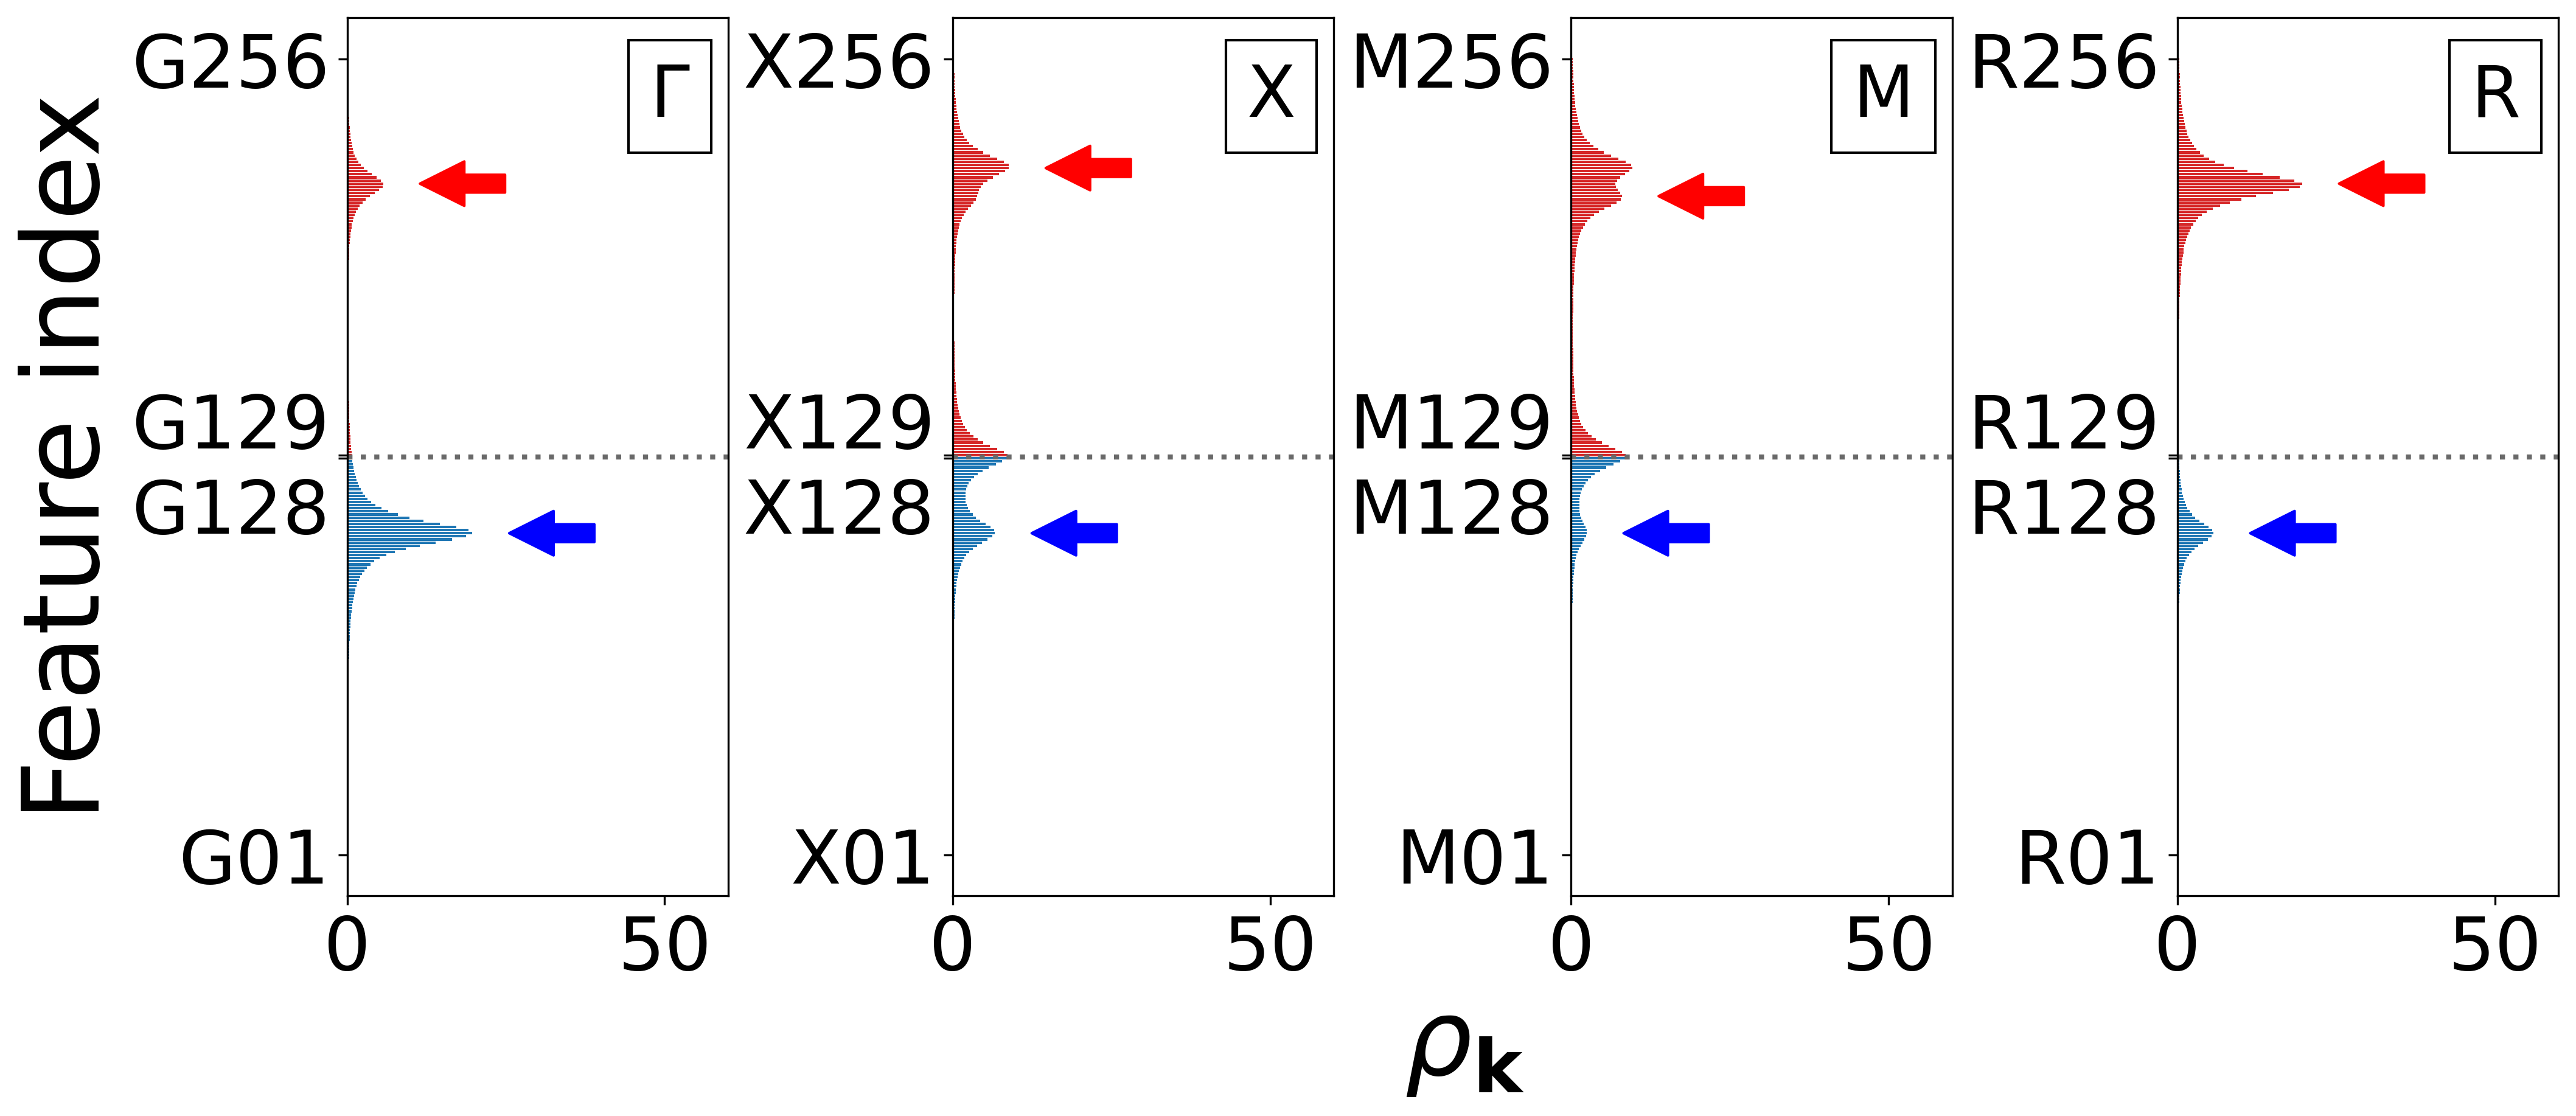

In [5]:
ShowPeak(name, 'dos_GK_eta0.30_bins256.h5', 'g', 0, 6, 6, fermi_idx=0, xlim=50)

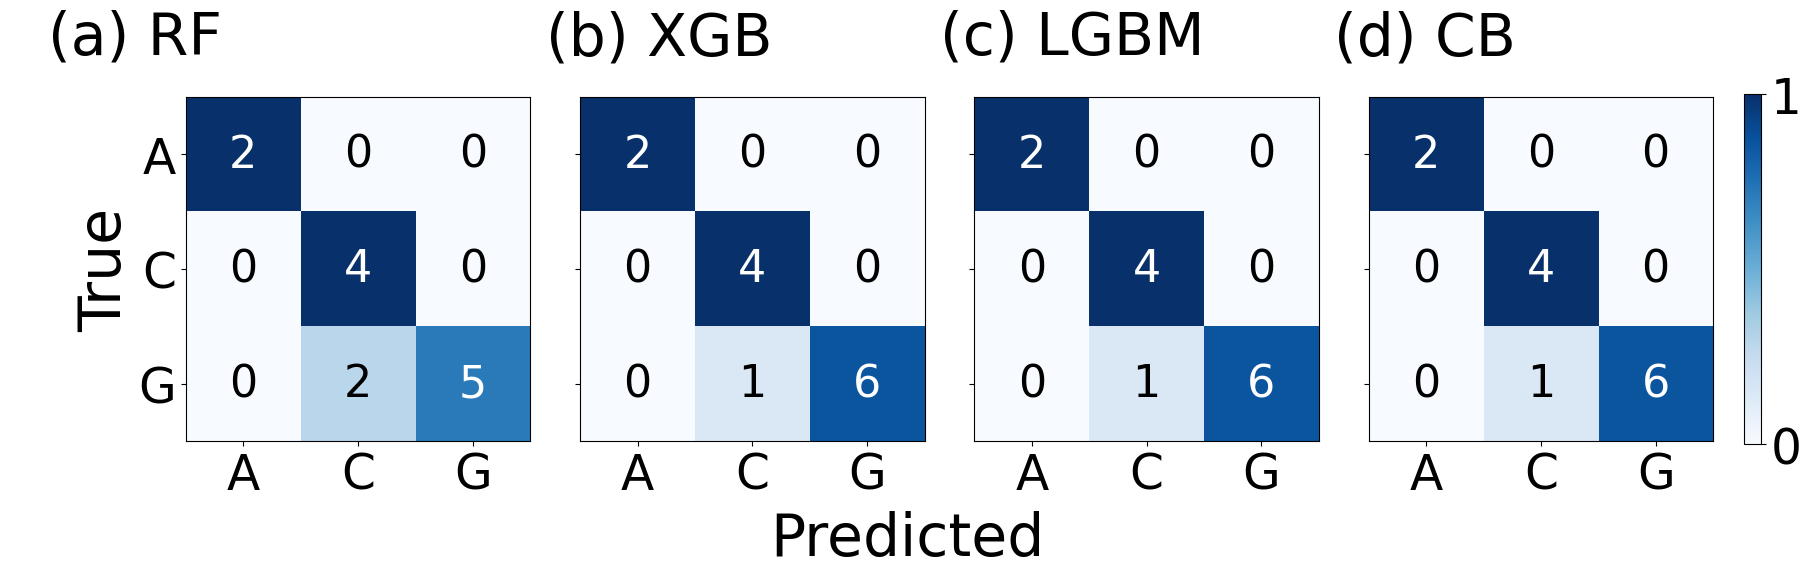

In [6]:
kn = 'peak_GK_eta0.10_bins256.h5'
dn = 'peak_DK_eta0.10_bins256.h5'
ShowConfMats([kn, dn], mcns, mcnfs)

In [8]:
kn = 'peak_GK_eta0.10_bins256.h5'
dn = 'peak_DK_eta0.10_bins256.h5'
for mcn in mcns:
    y = ms.Validate(kn, dn, mcn, verbose=False)
    print(mcn,'\n',y[4].loc[:, dmft_cols].rename(columns=dmft_dict))

rf 
      JU   Hz    D    U type type_p                   score
0   0.0  0.2  0.0  5.0    g      g  ['0.06' '0.29' '0.65']
1   0.0  0.2  5.0  5.0    g      c  ['0.01' '0.90' '0.09']
2   0.0  1.0  0.0  5.0    g      g  ['0.00' '0.29' '0.71']
3   0.0  2.0  0.0  6.0    c      c  ['0.01' '0.96' '0.03']
4   1.0  2.0  0.0  7.0    a      a  ['0.98' '0.01' '0.01']
5   0.0  2.0  0.0  7.0    c      c  ['0.00' '0.96' '0.04']
6   0.0  0.2  0.0  7.0    g      g  ['0.00' '0.27' '0.73']
7   0.0  2.0  0.0  5.0    g      g  ['0.00' '0.08' '0.92']
8   0.0  2.0  0.0  7.0    a      a  ['0.75' '0.24' '0.01']
9   1.0  0.2  0.0  7.0    c      c  ['0.00' '0.99' '0.01']
10  1.0  0.0  0.0  7.0    g      g  ['0.01' '0.15' '0.84']
11  0.0  0.2  0.0  7.0    c      c  ['0.00' '0.94' '0.06']
12  0.0  0.0  0.0  7.0    g      c  ['0.00' '0.74' '0.26']
xgb 
      JU   Hz    D    U type type_p                   score
0   0.0  0.2  0.0  5.0    g      g  ['0.00' '0.04' '1.00']
1   0.0  0.2  5.0  5.0    g      c  ['0.00' '

## DOS

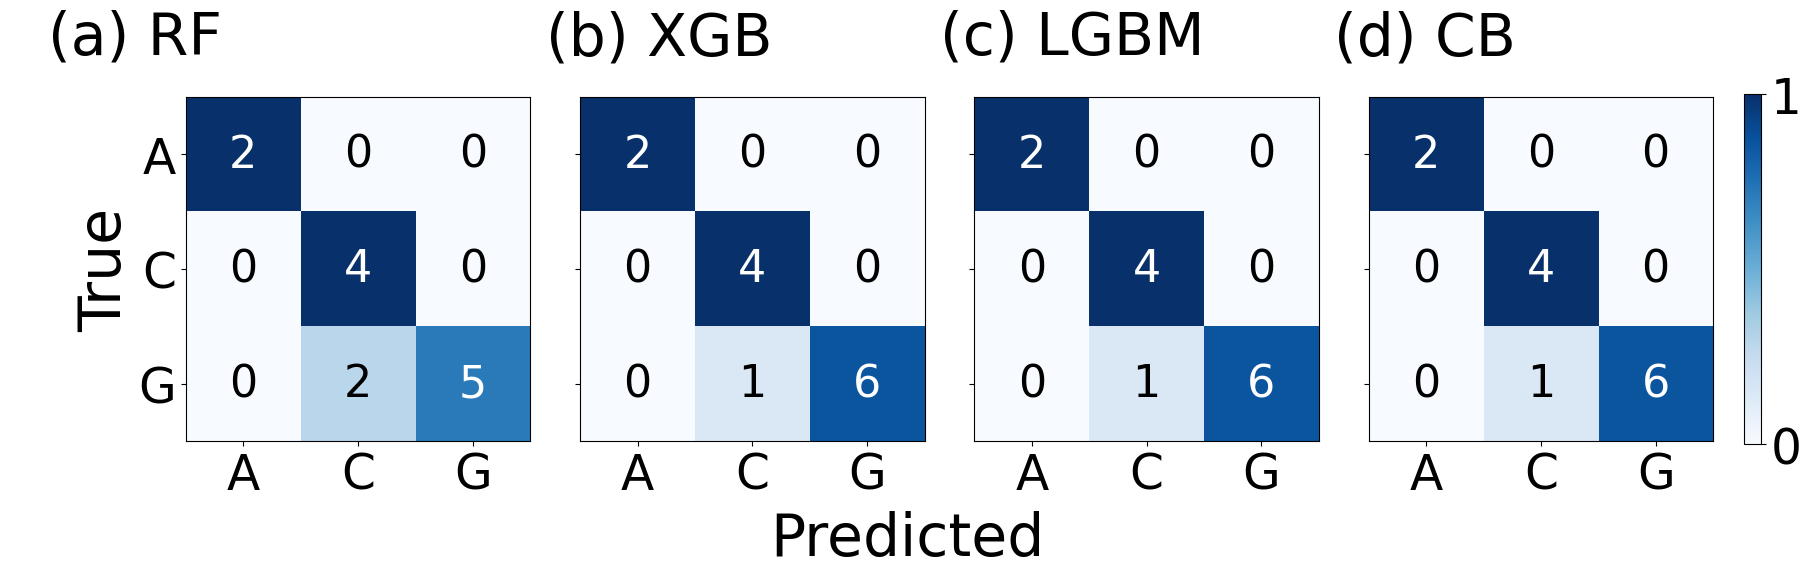

In [9]:
kn = 'dos_GK_eta0.10_bins512.h5'
dn = 'dos_DK_eta0.10_bins512.h5'
ShowConfMats([kn, dn], mcns, mcnfs)

In [10]:
kn = 'dos_GK_eta0.10_bins512.h5'
dn = 'dos_DK_eta0.10_bins512.h5'
for mcn in mcns:
    y = ms.Validate(kn, dn, mcn, verbose=False)
    print(mcn,'\n',y[4].loc[:, dmft_cols].rename(columns=dmft_dict))

rf 
      JU   Hz    D    U type type_p                   score
0   0.0  0.2  0.0  5.0    g      c  ['0.07' '0.49' '0.44']
1   0.0  0.2  5.0  5.0    g      c  ['0.01' '0.96' '0.03']
2   0.0  1.0  0.0  5.0    g      g  ['0.04' '0.38' '0.58']
3   0.0  2.0  0.0  6.0    c      c  ['0.06' '0.89' '0.05']
4   1.0  2.0  0.0  7.0    a      a  ['0.92' '0.06' '0.02']
5   0.0  2.0  0.0  7.0    c      c  ['0.03' '0.90' '0.07']
6   0.0  0.2  0.0  7.0    g      g  ['0.03' '0.39' '0.58']
7   0.0  2.0  0.0  5.0    g      g  ['0.04' '0.39' '0.57']
8   0.0  2.0  0.0  7.0    a      a  ['0.78' '0.22' '0.00']
9   1.0  0.2  0.0  7.0    c      c  ['0.00' '0.96' '0.04']
10  1.0  0.0  0.0  7.0    g      g  ['0.05' '0.18' '0.77']
11  0.0  0.2  0.0  7.0    c      c  ['0.02' '0.88' '0.10']
12  0.0  0.0  0.0  7.0    g      g  ['0.05' '0.45' '0.50']
xgb 
      JU   Hz    D    U type type_p                   score
0   0.0  0.2  0.0  5.0    g      g  ['0.00' '0.01' '0.98']
1   0.0  0.2  5.0  5.0    g      c  ['0.00' '

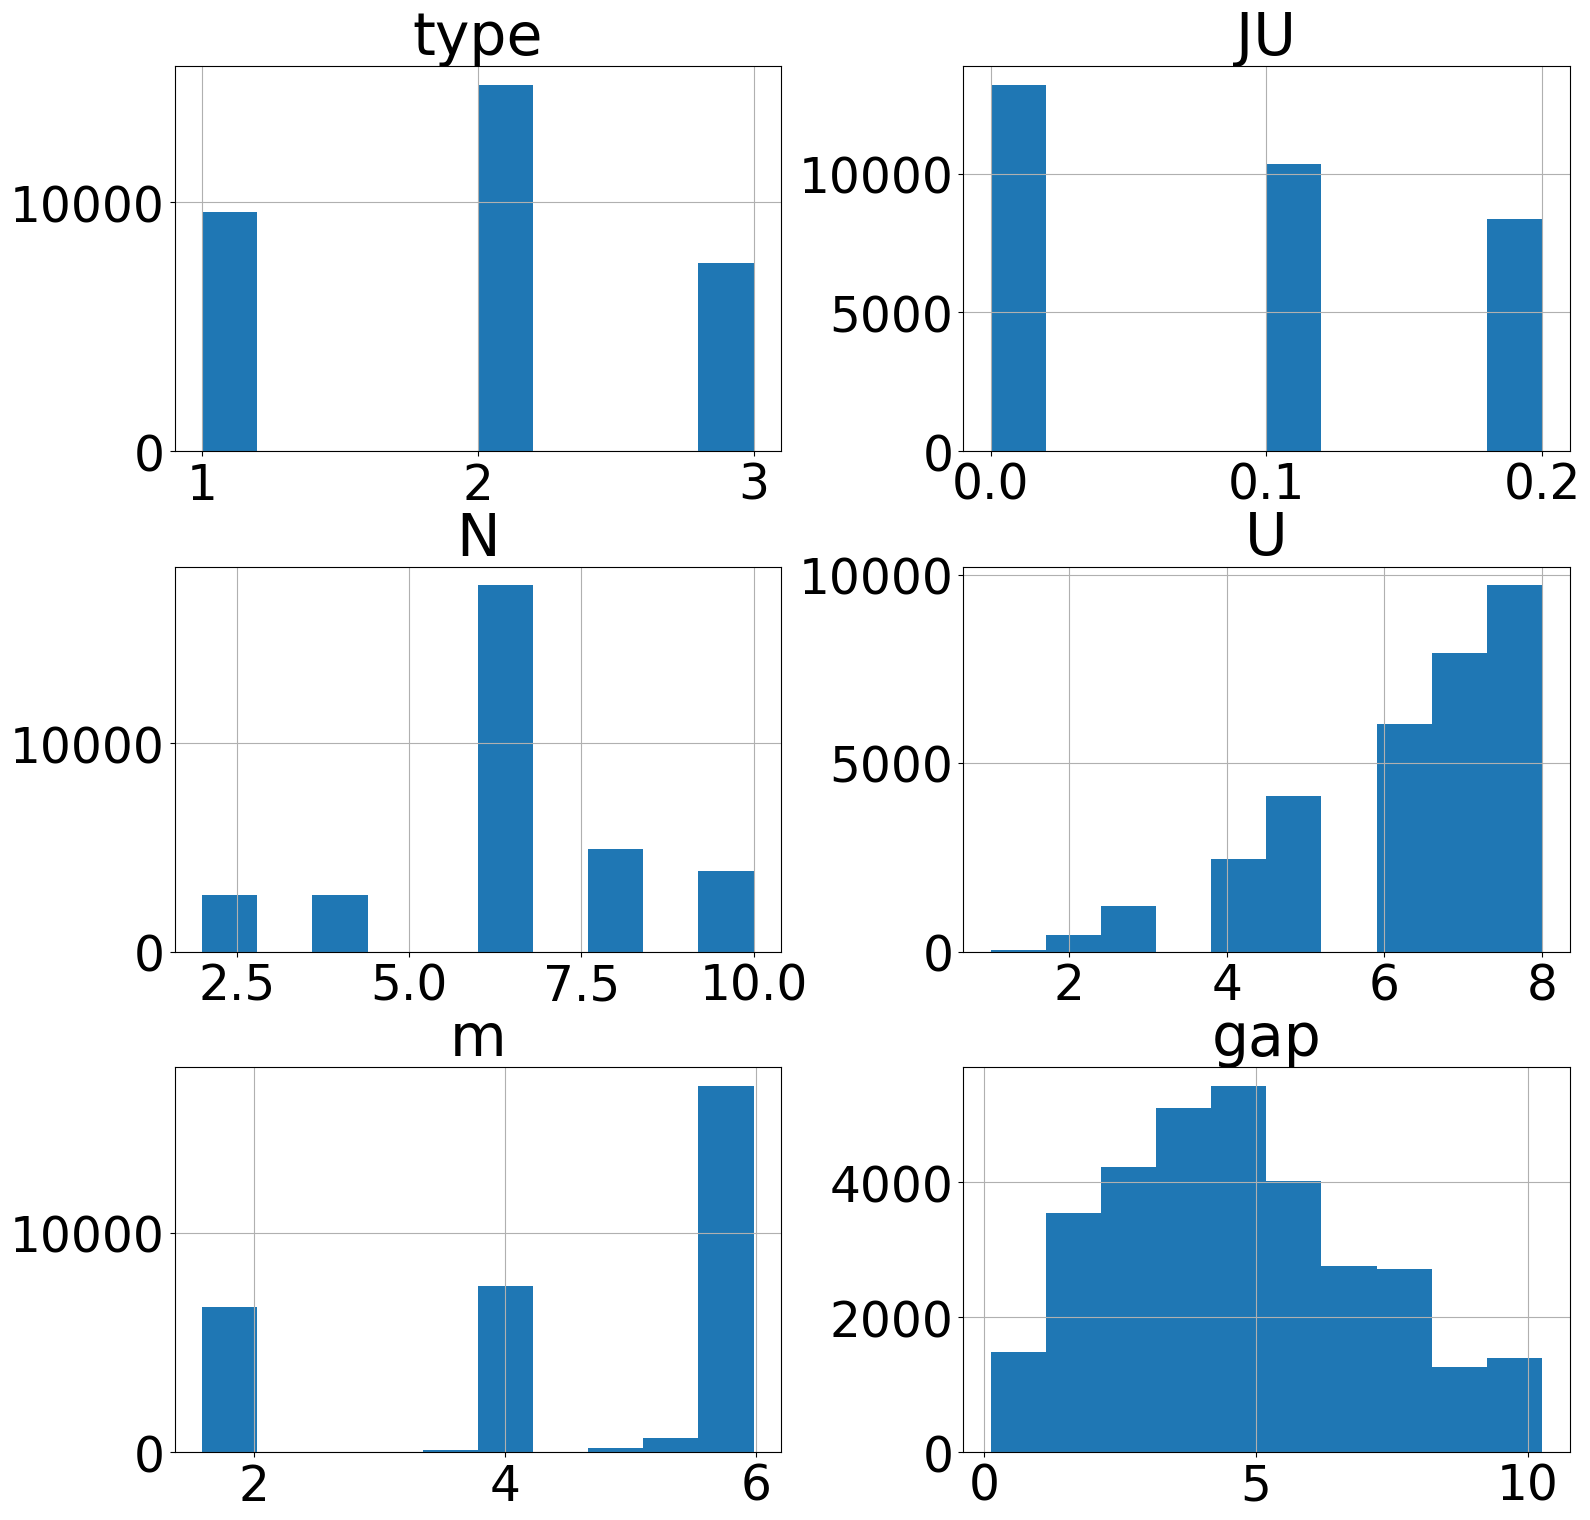

In [35]:
kn = 'dos_GK_eta0.10_bins512.h5'
X_train, X_test, y_train, y_test = ms.Train(kn, 'rf', check_dataset=True)
idx_train = y_train.index

with open('%s/params_G.txt' % ms.path_save, 'r') as f:
    df_train = pd.read_csv('%s/params_G.txt' % ms.path_save, sep='\s+').loc[idx_train, :]

df_train['type'] = df_train['type'].apply(np.floor)
hist = df_train.loc[:, ['type', 'JU', 'N', 'U', 'm', 'gap']].hist(figsize=(18, 18))

## Feature selection by PCA

FileNotFoundError: [Errno 2] No such file or directory: 'output/baoso3_dU1.0//magstr/params_M.txt'

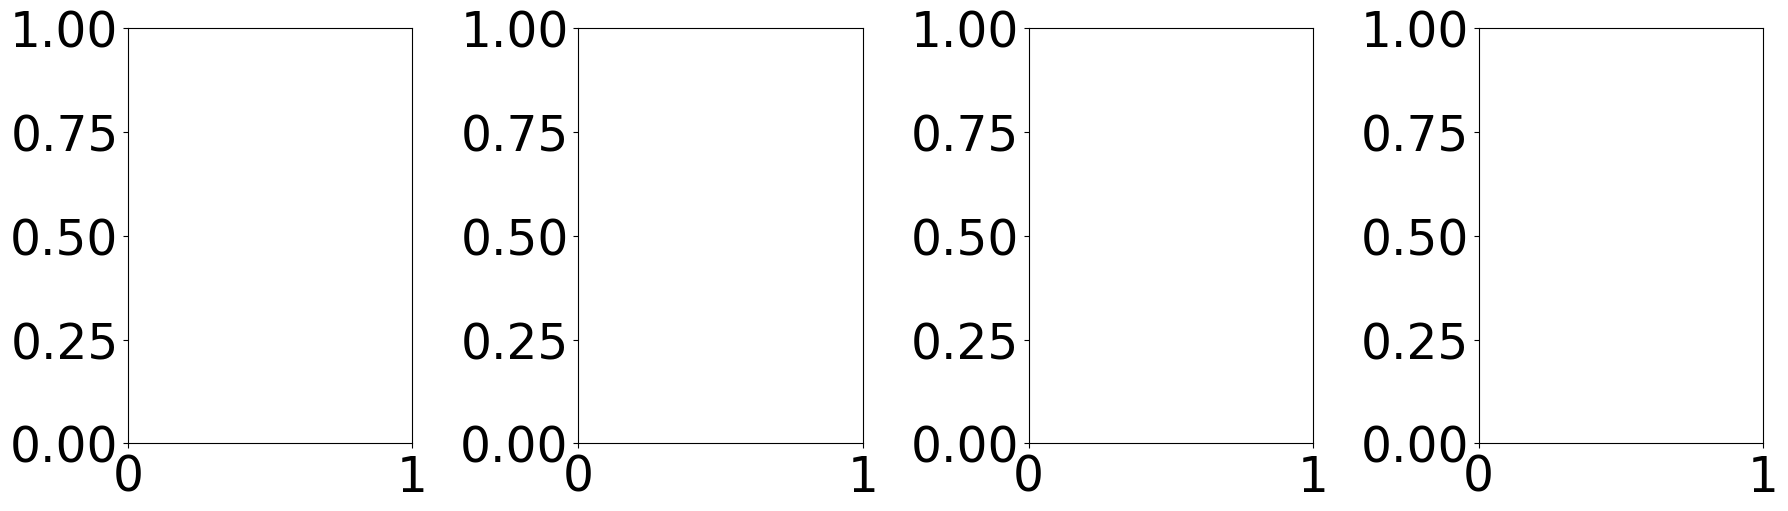

In [2]:
dn = 'dos_MK_eta0.10.h5'
ShowConfMats(dn, mcns, mcnfs, pca=10)

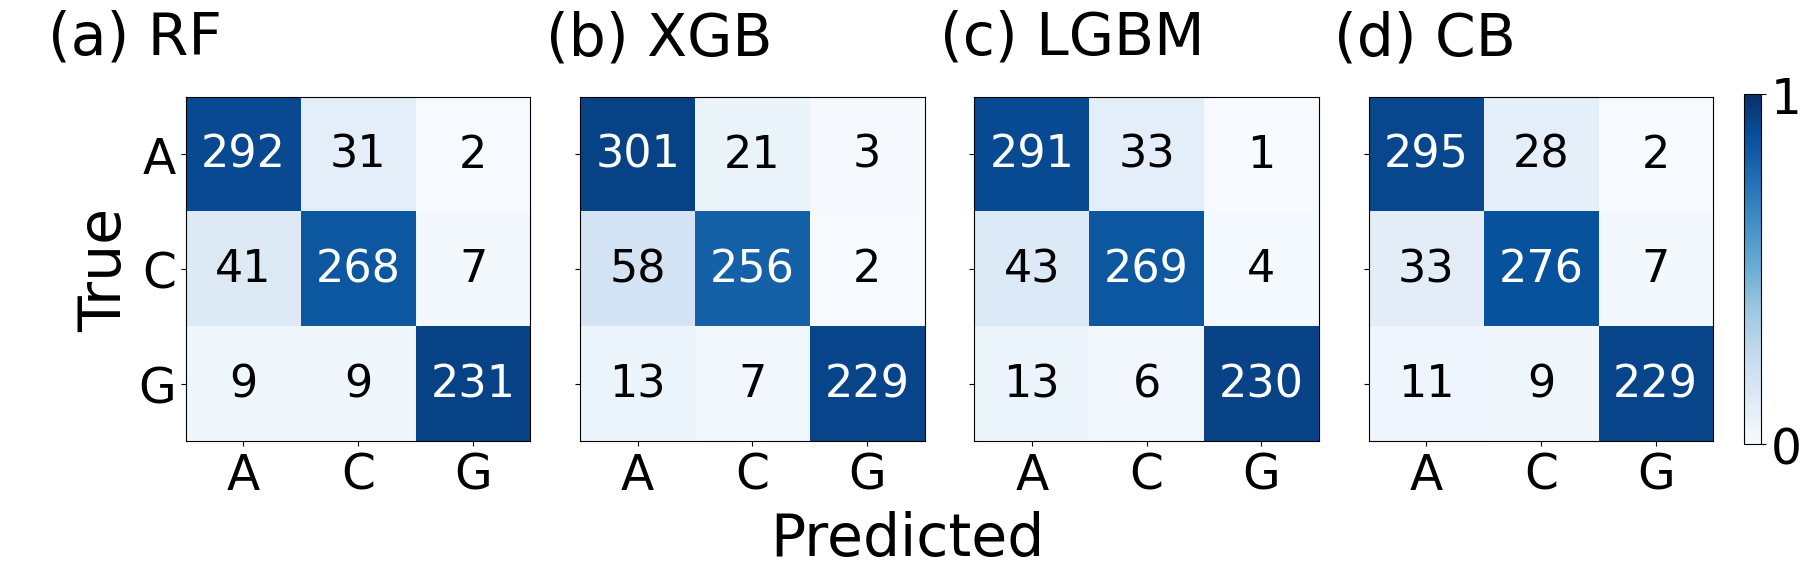

In [2]:
dn = 'dos_M_eta0.10.h5'
ShowConfMats(dn, mcns, mcnfs, pca=10)

## Unsupervised learning based on PCA

## Optimizing

### Resampling

### Hyperparameter tuning